# Exercise 6 - Dimensionality Reduction with PCA, Kernel PCA and FA(Factor Analysis)

## Data preparation
Your objective here is to get the flow data used for dimensionality reduction; The provided dataset is 5-minute observations on highway microwave sensors and needs to be in a format ready for dimensionality reduction. Thus, we represent days as ordered vectors of day-time observations of size 288 (there are 288, 5-minute time observations)

In [17]:
import pandas as pd
import numpy as np
#upload the dataset by downloading both datasets from canvas and upload it on colab
data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")
data_df

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
104838,"E4S 56,780",20211231,23:35:00,23:40:00,283,19.58,115
104839,"E4S 56,780",20211231,23:40:00,23:45:00,284,19.47,87
104840,"E4S 56,780",20211231,23:45:00,23:50:00,285,19.77,130
104841,"E4S 56,780",20211231,23:50:00,23:55:00,286,18.79,129


In [18]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])
# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)
# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])
# Define the total number of 5-minute intervals in a day
nintvals = 288

In [19]:
# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)
# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])
    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])
        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]
# Print the resulting 'vectorized_day_dataset' and the size of vector
print(vectorized_day_dataset)
print(vectorized_day_dataset.shape)

[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]
(365, 288)


In [20]:
# print the number of days with missing value
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value:',np.size(np.where(nans_per_day > 0),1))

number of days with missing value: 28


Drop the days with missing valus

In [21]:
# Drop the days with missing valus
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
# days_not_nans = days[np.where(nans_per_day == 0)[0]]
print(vectorized_day_dataset_no_nans.shape)

(337, 288)


### Task 1: Perform PCA in dataset 1 for dimensionality reduction

In [22]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

 Step 1: Overview of the Dataset
 Load and inspect the dataset

In [34]:
data = pd.DataFrame(vectorized_day_dataset_no_nans)
data.head()  # Display the first few rows
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,...,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,33.314540,32.985163,32.566766,31.771513,31.545994,29.896142,28.798220,27.673591,26.836795,26.332344,...,44.919881,45.931751,44.670623,42.902077,40.703264,39.501484,37.543027,36.169139,35.952522,33.753709
std,15.895554,15.590837,15.211089,15.052824,14.602423,14.448942,14.522794,13.478609,13.888804,13.761443,...,19.550670,19.604682,18.469283,18.352514,18.369741,18.716577,17.610673,17.948285,18.085877,16.511590
min,5.000000,8.000000,6.000000,3.000000,6.000000,7.000000,6.000000,7.000000,3.000000,8.000000,...,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000
25%,22.000000,22.000000,22.000000,20.000000,21.000000,19.000000,18.000000,19.000000,17.000000,17.000000,...,31.000000,31.000000,32.000000,30.000000,29.000000,26.000000,24.000000,23.000000,23.000000,22.000000
50%,29.000000,29.000000,29.000000,29.000000,28.000000,26.000000,26.000000,25.000000,23.000000,23.000000,...,43.000000,44.000000,42.000000,41.000000,38.000000,36.000000,34.000000,32.000000,33.000000,31.000000
75%,41.000000,42.000000,40.000000,40.000000,39.000000,38.000000,36.000000,34.000000,32.000000,32.000000,...,58.000000,59.000000,55.000000,54.000000,50.000000,48.000000,46.000000,45.000000,46.000000,42.000000
max,101.000000,83.000000,92.000000,81.000000,83.000000,78.000000,73.000000,109.000000,91.000000,121.000000,...,107.000000,101.000000,103.000000,104.000000,103.000000,115.000000,101.000000,130.000000,129.000000,117.000000


Step 2: Data Preprocessing (Normalization)

In [24]:
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[ 0.35820798, -0.96258119, -0.43235105, ..., -0.23263163,
         0.16875098,  0.01493842],
       [-0.20883002, -0.06328257, -0.36651178, ...,  0.43695009,
         0.27949894,  0.3182063 ],
       [ 0.16919531,  0.70754483,  1.27946997, ...,  0.77174095,
         0.50099486, -0.65225092],
       ...,
       [-0.83887223,  0.06518867, -0.1031547 , ...,  0.10215923,
         0.33487292,  0.13624557],
       [ 0.16919531,  0.45060236, -0.49819032, ...,  0.10215923,
         1.11010866,  0.07559199],
       [-0.01981735, -0.06328257,  0.09436311, ...,  5.23561911,
         5.1524093 ,  5.0491852 ]])

Step 3: Perform PCA for Dimensionality Reduction

In [25]:
pca = PCA(n_components=10)  # Adjust the number of components (dimensions) as needed
data_pca = pca.fit_transform(data_normalized)
print(data_pca)
print(data_pca.shape)

[[ 22.5990504   32.36356427 -11.4957345  ...  13.34936591  12.95103632
    2.89641497]
 [ 17.25353727   6.07639879   3.12115793 ...  -1.99218524  -3.70265659
   -0.19024006]
 [ 18.05538293   8.4369415    0.50658252 ...  -0.19761678  -1.41989653
   -0.84142421]
 ...
 [  3.4775234   -2.45274731   0.9951784  ...   1.14161152  -1.84253869
   -0.82809526]
 [  4.41769458   0.10587539  -0.84793378 ...   0.44717098  -1.01107513
   -1.04005444]
 [ 12.82740206  16.62396057   5.83039331 ...  -4.84840592  -1.08985085
    0.51700347]]
(337, 10)


Step 4: Assess Performance of PCA

In [50]:
# Investigate Explained Variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance Ratio: {explained_variance}')

Explained Variance Ratio: [0.49522079 0.13374111 0.07623987 0.04776844 0.02627887 0.02292467
 0.01509669 0.01306283 0.01076628 0.00959517]


Stability Analysis for PCA involves assessing the variability of principal component scores across different random splits or subsets of the data. This can be done to ensure that the identified principal components are robust and not overly influenced by specific data points.

In [51]:
# Conduct Stability Analysis
num_runs = 10  # Number of times to run PCA with different random seeds

prop_data_used = 0.8 # Define the proportion of data to use in each iteration (e.g., 80%)

for i in range(num_runs):
    # Randomly select a subset of the data
    prop_data_used
    subset_indices = np.random.choice(data.shape[0], size=int(prop_data_used * data.shape[0]), replace=False)
    subset_data = data.loc[subset_indices]
    # Fit PCA on the subset
    pca = PCA(n_components=10)  # Change random_state for each run
    X_pca = pca.fit_transform(subset_data)
    
    explained_variance = pca.explained_variance_ratio_
    print(f'Run {i+1} - Explained Variance Ratio: {explained_variance}')

Run 1 - Explained Variance Ratio: [0.47500709 0.16050968 0.08819106 0.04704814 0.02554043 0.01991379
 0.01312146 0.01197244 0.00956625 0.00897602]
Run 2 - Explained Variance Ratio: [0.472617   0.15482763 0.08758378 0.04546237 0.0252406  0.02380161
 0.01340479 0.01189679 0.01104009 0.00881204]
Run 3 - Explained Variance Ratio: [0.49864384 0.13530823 0.077477   0.04632566 0.02754178 0.02051886
 0.01410402 0.0126299  0.01029904 0.0088853 ]
Run 4 - Explained Variance Ratio: [0.4852613  0.15877934 0.083395   0.04559597 0.02383024 0.02287186
 0.01359094 0.0126798  0.00954968 0.00824872]
Run 5 - Explained Variance Ratio: [0.49228893 0.14095184 0.08223949 0.04802001 0.0271886  0.0231564
 0.01500226 0.01063532 0.00987908 0.00884497]
Run 6 - Explained Variance Ratio: [0.49494365 0.14539768 0.08402673 0.04615302 0.02443028 0.02301466
 0.01221812 0.01167871 0.01036913 0.00838824]
Run 7 - Explained Variance Ratio: [0.49115366 0.15266851 0.07779513 0.04839382 0.02672457 0.02280797
 0.01413151 0.0116

### Task 2: Perform PCA in dataset 1 for outlier detection

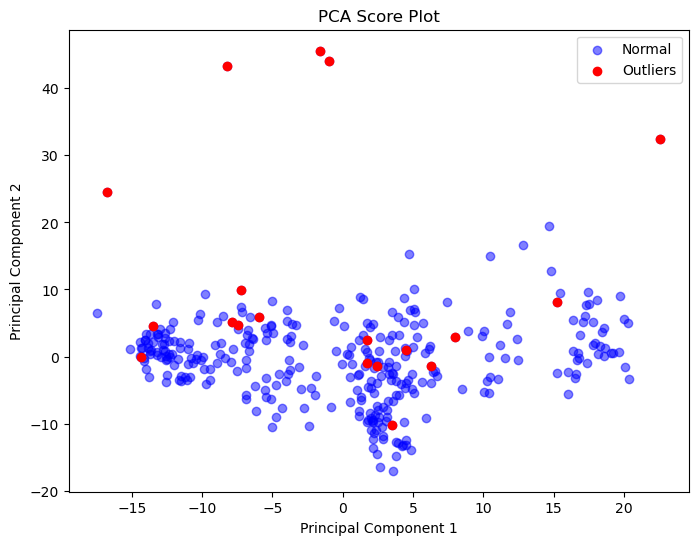

Number of detected outliers: 19
Detected outliers: [  0  40 113 175 176 202 213 218 230 231 248 253 258 279 280 288 299 315
 329]


In [233]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess the data
data = pd.DataFrame(vectorized_day_dataset_no_nans)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(data)

# Apply PCA for reconstruction
pca = PCA(n_components=2)
X_reconstructed = pca.inverse_transform(pca.fit_transform(X_normalized))

# Calculate reconstruction errors
reconstruction_error = np.mean(np.square(X_normalized - X_reconstructed), axis=1)

# Set a threshold for the reconstruction error
threshold = 1  # Adjust as needed

# Identify outliers
outliers = np.where(reconstruction_error > threshold)[0]

# Visual Inspection of PCA Score Plots
pca_scores = pca.fit_transform(X_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c='b', alpha=0.5, label='Normal')
plt.scatter(pca_scores[outliers, 0], pca_scores[outliers, 1], c='r', label='Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA Score Plot')
plt.show()

# Print the indices of detected outliers
print(f'Number of detected outliers: {outliers.shape[0]}')
print(f'Detected outliers: {outliers}')


### Using kernel PCA

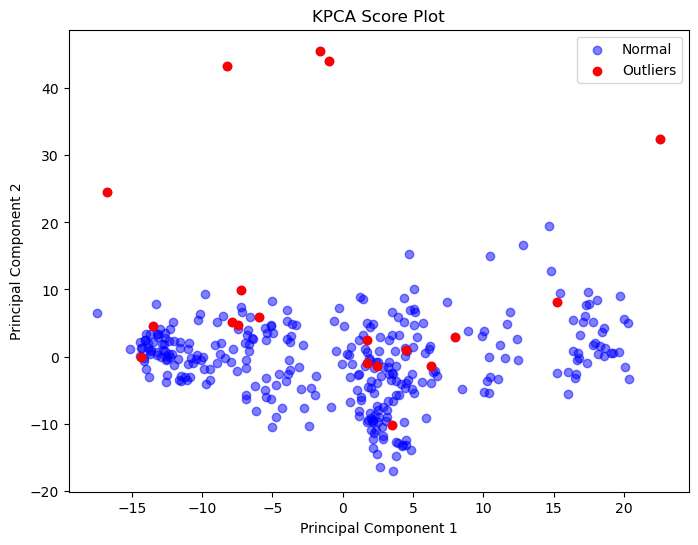

Number of detected outliers: 19
Detected outliers: [  0  40 113 175 176 202 213 218 230 231 248 253 258 279 280 288 299 315
 329]


In [232]:
from sklearn.decomposition import KernelPCA

# Load and preprocess the data
data = pd.DataFrame(vectorized_day_dataset_no_nans)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(data)

# Step 1: Visual Inspection of Kernel PCA Score Plots
# Perform Kernel PCA
# Kernel functions : 'linear', 'rbf', 'poly', 'sigmoid'.
kpca = KernelPCA(kernel='linear', n_components=2, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(X_normalized)


# Step 2: Detecting Outliers through Computing Reconstruction Errors
# Reconstruct the data from the reduced kernel PCA space
X_reconstructed = kpca.inverse_transform(X_kpca)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.square(X_normalized - X_reconstructed), axis=1)

# Define a threshold for outliers
threshold = 1  # Adjust as needed
kpca_scores = kpca.fit_transform(X_normalized)
# Identify outliers
outliers = np.where(reconstruction_error > threshold)[0]

plt.figure(figsize=(8, 6))
plt.scatter(kpca_scores[:, 0], kpca_scores[:, 1], c='b', alpha=0.5, label='Normal')
plt.scatter(kpca_scores[outliers, 0], kpca_scores[outliers, 1], c='r', label='Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('KPCA Score Plot')
plt.show()
# Print the number of detected outliers
print(f'Number of detected outliers: {outliers.shape[0]}')
print(f'Detected outliers: {outliers}')



### Task 3: Identify the underlying latent factors that explain the observed correlations among several variables using FA 

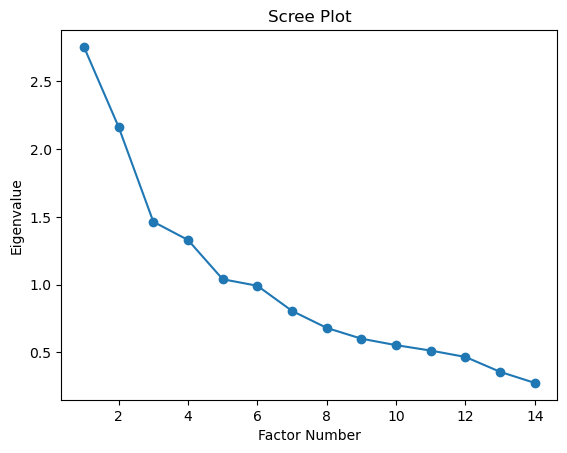

Factor Loadings:                      Factor 1  Factor 2  Factor 3  Factor 4  Factor 5
Price                0.578931  0.234152 -0.108803 -0.005588 -0.069328
Safety              -0.306536  0.229736  0.167865  0.065558 -0.243916
Exterior_Looks       0.090185  0.050722  0.026241 -0.542464  0.312042
Space_comfort       -0.022750  0.881709  0.041921 -0.055038  0.034016
Technology           0.000961  0.278548  0.140475  0.061123  0.005776
After_Sales_Service -0.012211  0.040035  0.946527 -0.005035 -0.009768
Resale_Value         0.725386 -0.204593  0.081063 -0.052370 -0.102032
Fuel_Type            0.025645  0.517666  0.107412  0.017839 -0.134947
Fuel_Efficiency      0.381540  0.007924  0.329103  0.226688  0.216041
Color                0.033070 -0.052346  0.016076  0.783525  0.090678
Maintenance          0.552883  0.114794 -0.007430  0.263017  0.006467
Test_drive           0.059225 -0.017722  0.234800 -0.063657  0.438696
Product_reviews      0.331873  0.245901 -0.077326  0.123717  0.351592
Tes

In [221]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
# pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Step 1: Data Preprocessing
# Load and preprocess the data
data = pd.read_csv('Dataset 2.csv')

# Step 2: Exploratory Factor Analysis
# Initialize FactorAnalyzer object
fa = FactorAnalyzer()

# # Experiment with different rotation methods (e.g., Varimax, Promax, and Oblimin)
# # Varimax Rotation
# fa.set_params(rotation='varimax')
# fa.fit(data)

# # Promax Rotation
# fa.set_params(rotation='promax')
# fa.fit(data)

# # Oblimin Rotation
fa.set_params(rotation='oblimin')
fa.fit(data)

# Step 3: Determine the Number of Factors
# Kaiser's Criterion
eigenvalues, _ = fa.get_eigenvalues()
num_factors_kaiser = sum(eigenvalues > 1)  # Select factors with eigenvalues > 1

# Scree Plot Examination
plt.scatter(range(1, data.shape[1]+1), eigenvalues)
plt.plot(range(1, data.shape[1]+1), eigenvalues)
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.show()

# Step 4: Compute Factor Loadings
fa.set_params(n_factors=num_factors_kaiser)  # Use the determined number of factors
fa.fit(data)
factor_loadings = fa.loadings_

# Step 5: Interpret the Factors
# (Based on factor loadings and variable names)
# Provide meaningful labels/names to the identified factors based on interpretation
factor_names = ['Factor 1', 'Factor 2','Factor 3', 'Factor 4','Factor 5']  # Adapt as needed

# Print factor loadings
factor_loadings = pd.DataFrame(factor_loadings, index=data.columns, columns=factor_names)
print("Factor Loadings:", factor_loadings)
# print(pd.DataFrame(factor_loadings, index=data.columns, columns=factor_names))

# You can further interpret and label the factors based on the loadings and variable names.

# Additional: Assessing Factorability
bartlett_test_statistic, p_value = calculate_bartlett_sphericity(data)
kmo_score = calculate_kmo(data)

print(f"\nBartlett's Test Statistic: {bartlett_test_statistic}")
print(f"P-value: {p_value}")
print(f"KMO Score: {kmo_score}")

#### Nest step: Let's sort the dataframe based on each factor using cut off value 0.5.

In [222]:
factor_loadings.sort_values('Factor 1', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Resale_Value,0.725386,-0.204593,0.081063,-0.052370,-0.102032
Price,0.578931,0.234152,-0.108803,-0.005588,-0.069328
Maintenance,0.552883,0.114794,-0.007430,0.263017,0.006467
Fuel_Efficiency,0.381540,0.007924,0.329103,0.226688,0.216041
Product_reviews,0.331873,0.245901,-0.077326,0.123717,0.351592
Exterior_Looks,0.090185,0.050722,0.026241,-0.542464,0.312042
Test_drive,0.059225,-0.017722,0.234800,-0.063657,0.438696
Color,0.033070,-0.052346,0.016076,0.783525,0.090678
Fuel_Type,0.025645,0.517666,0.107412,0.017839,-0.134947
Technology,0.000961,0.278548,0.140475,0.061123,0.005776


In [223]:
factor_loadings.sort_values('Factor 2', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Space_comfort,-0.022750,0.881709,0.041921,-0.055038,0.034016
Fuel_Type,0.025645,0.517666,0.107412,0.017839,-0.134947
Technology,0.000961,0.278548,0.140475,0.061123,0.005776
Product_reviews,0.331873,0.245901,-0.077326,0.123717,0.351592
Price,0.578931,0.234152,-0.108803,-0.005588,-0.069328
Safety,-0.306536,0.229736,0.167865,0.065558,-0.243916
Maintenance,0.552883,0.114794,-0.007430,0.263017,0.006467
Exterior_Looks,0.090185,0.050722,0.026241,-0.542464,0.312042
After_Sales_Service,-0.012211,0.040035,0.946527,-0.005035,-0.009768
Testimonials,-0.233455,0.039087,-0.035677,0.078491,0.627388


In [224]:
factor_loadings.sort_values('Factor 3', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
After_Sales_Service,-0.012211,0.040035,0.946527,-0.005035,-0.009768
Fuel_Efficiency,0.381540,0.007924,0.329103,0.226688,0.216041
Test_drive,0.059225,-0.017722,0.234800,-0.063657,0.438696
Safety,-0.306536,0.229736,0.167865,0.065558,-0.243916
Technology,0.000961,0.278548,0.140475,0.061123,0.005776
Fuel_Type,0.025645,0.517666,0.107412,0.017839,-0.134947
Resale_Value,0.725386,-0.204593,0.081063,-0.052370,-0.102032
Space_comfort,-0.022750,0.881709,0.041921,-0.055038,0.034016
Exterior_Looks,0.090185,0.050722,0.026241,-0.542464,0.312042
Color,0.033070,-0.052346,0.016076,0.783525,0.090678


In [225]:
factor_loadings.sort_values('Factor 4', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Color,0.033070,-0.052346,0.016076,0.783525,0.090678
Maintenance,0.552883,0.114794,-0.007430,0.263017,0.006467
Fuel_Efficiency,0.381540,0.007924,0.329103,0.226688,0.216041
Product_reviews,0.331873,0.245901,-0.077326,0.123717,0.351592
Testimonials,-0.233455,0.039087,-0.035677,0.078491,0.627388
Safety,-0.306536,0.229736,0.167865,0.065558,-0.243916
Technology,0.000961,0.278548,0.140475,0.061123,0.005776
Fuel_Type,0.025645,0.517666,0.107412,0.017839,-0.134947
After_Sales_Service,-0.012211,0.040035,0.946527,-0.005035,-0.009768
Price,0.578931,0.234152,-0.108803,-0.005588,-0.069328


In [226]:
factor_loadings.sort_values('Factor 5', ascending=False)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Testimonials,-0.233455,0.039087,-0.035677,0.078491,0.627388
Test_drive,0.059225,-0.017722,0.234800,-0.063657,0.438696
Product_reviews,0.331873,0.245901,-0.077326,0.123717,0.351592
Exterior_Looks,0.090185,0.050722,0.026241,-0.542464,0.312042
Fuel_Efficiency,0.381540,0.007924,0.329103,0.226688,0.216041
Color,0.033070,-0.052346,0.016076,0.783525,0.090678
Space_comfort,-0.022750,0.881709,0.041921,-0.055038,0.034016
Maintenance,0.552883,0.114794,-0.007430,0.263017,0.006467
Technology,0.000961,0.278548,0.140475,0.061123,0.005776
After_Sales_Service,-0.012211,0.040035,0.946527,-0.005035,-0.009768


So the interpretation of the factors is below:
1. Factor 1: Resale_Value, Price, Maintenance
2. Factor 2: Space_comfort, Fuel_Type
3. Factor 3: After_Sales_Service
4. Factor 4: Color
5. Factor 5: Testimonials

Try other parameters and see the results.

### Assignment task: Compare the performance of PCA and kernel PCA for dimensionality reduction in dataset 1.

Text(0.5, 1.0, 'Kernel PCA (Polynomial)')

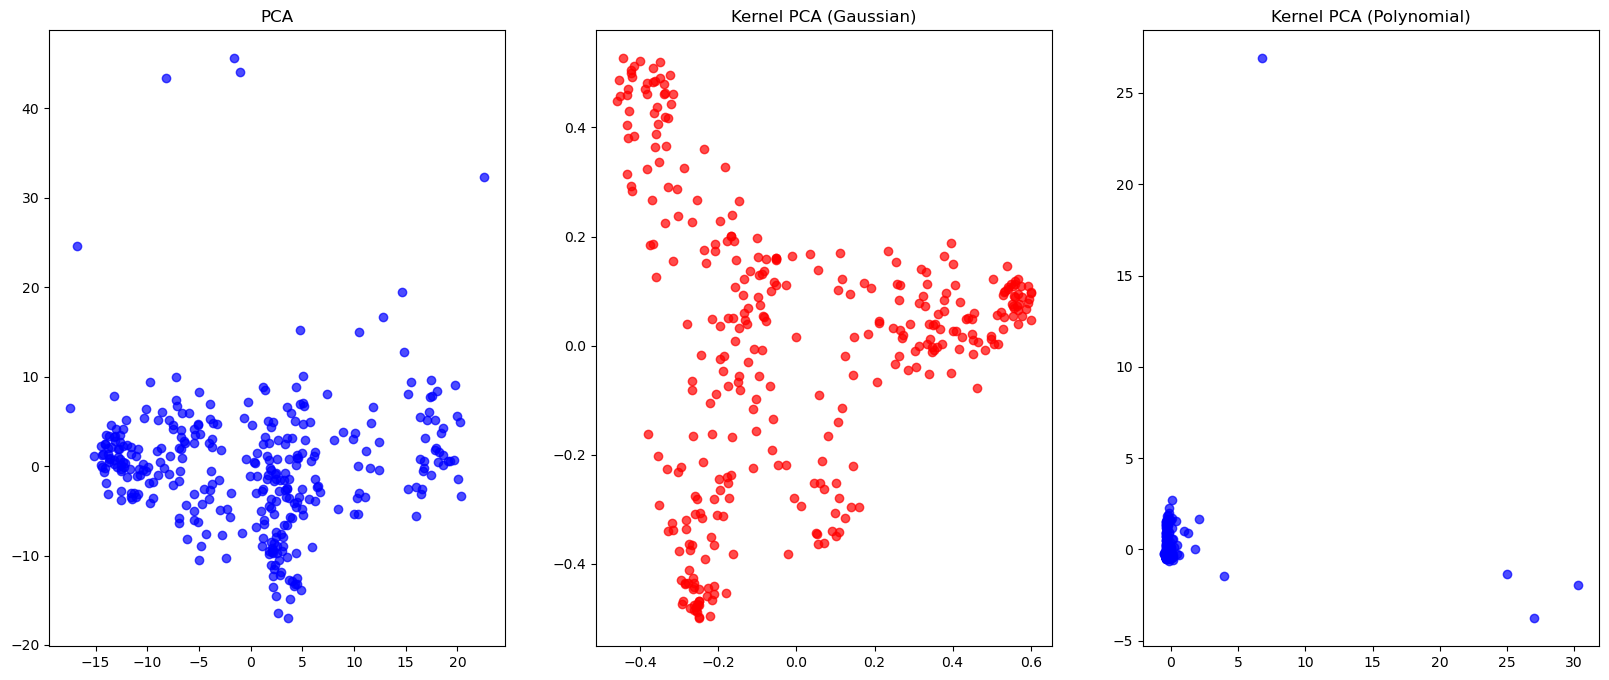

In [197]:
# Import necessary libraries
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Assuming you have your dataset loaded as 'data'
# If not, replace this with loading your actual dataset

da = pd.DataFrame(vectorized_day_dataset_no_nans)
scaler = StandardScaler()
data = scaler.fit_transform(da)

# Step 1: Perform PCA for dimensionality reduction
pca = PCA(n_components=2)  # Set the desired number of components
pca_result = pca.fit_transform(data)

# Step 2: Perform Kernel PCA with different kernel functions
# kernel functions : 'linear', 'rbf', 'poly', 'sigmoid'

kernel_pca_gaussian = KernelPCA(kernel='rbf', n_components=2)  # Gaussian kernel
kernel_pca_polynomial = KernelPCA(kernel='poly', n_components=2)  # Polynomial kernel

kpca_gaussian_result = kernel_pca_gaussian.fit_transform(data)
kpca_polynomial_result = kernel_pca_polynomial.fit_transform(data)

# Step 3: Pick the best kernel function based on your assessment
# You may evaluate the results using some metric or visual inspection

# For example, you can visualize the results
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='b', marker='o', alpha=0.7)
plt.title('PCA')

plt.subplot(1, 3, 2)
plt.scatter(kpca_gaussian_result[:, 0], kpca_gaussian_result[:, 1], c='r', marker='o', alpha=0.7)
plt.title('Kernel PCA (Gaussian)')

plt.subplot(1, 3, 3)
plt.scatter(kpca_polynomial_result[:, 0], kpca_polynomial_result[:, 1], c='b', marker='o', alpha=0.7)
plt.title('Kernel PCA (Polynomial)')

# Note: You might need to fine-tune parameters for the kernel functions (e.g., gamma for the Gaussian kernel) based on your specific dataset.


#### Provide a reflection on the results;
#### Compare the performance, interpret the results, and draw conclusions

In [8]:
import numpy as np
from sklearn.decomposition import PCA

# Generate example data (replace with your own dataset)
np.random.seed(0)
data = np.random.rand(100, 10)  # 100 samples, 10 variables

# Define the number of iterations for stability analysis
num_iterations = 2

# Define the proportion of data to use in each iteration (e.g., 80%)
prop_data_used = 0.8

# Initialize an array to store the principal component scores
all_pc_scores = []

# Perform PCA on different random subsets of the data
for _ in range(num_iterations):
    # Randomly select a subset of the data
    subset_indices = np.random.choice(data.shape[0], size=int(prop_data_used * data.shape[0]), replace=False)
    subset_data = data[subset_indices]
    
    # Fit PCA on the subset
    pca = PCA(n_components=2)
    pca.fit(subset_data)
    
    # Get the principal component scores for the entire dataset
    pc_scores = pca.transform(data)
    all_pc_scores.append(pc_scores)

# Calculate the mean and standard deviation of the principal component scores
mean_scores = np.mean(all_pc_scores, axis=0)
std_scores = np.std(all_pc_scores, axis=0)

# You can use 'mean_scores' and 'std_scores' for further analysis or visualization


In [9]:
all_pc_scores

[array([[ 0.5261839 , -0.12676593],
        [ 0.20998367,  0.15490989],
        [ 0.44511982,  0.17108198],
        [ 0.53831216,  0.20726065],
        [-0.48409812, -0.06844366],
        [-0.21702068, -0.21993009],
        [-0.14570683,  0.04301999],
        [-0.32291176, -0.38912048],
        [-0.13355232,  0.25347063],
        [ 0.32403038,  0.36988094],
        [-0.05965688,  0.09266381],
        [ 0.35781764, -0.53844858],
        [-0.06616401, -0.15374746],
        [ 0.09849508,  0.02275544],
        [ 0.09373239, -0.19778033],
        [ 0.58999338,  0.57652774],
        [ 0.03620508, -0.23835823],
        [-0.19771682, -0.03560912],
        [ 0.12007239, -0.21710527],
        [-0.33788659,  0.45766678],
        [ 0.02931306,  0.19950415],
        [-0.2765186 , -0.10946746],
        [ 0.59365615,  0.07414209],
        [-0.46043775,  0.26194253],
        [-0.6320572 , -0.24128883],
        [ 0.5259557 , -0.36715013],
        [-0.21300005,  0.65081232],
        [ 0.77304182, -0.066

In [14]:
import numpy as np
from sklearn.decomposition import PCA

# Generate example data (replace with your own dataset)
np.random.seed(0)
data = np.random.rand(100, 10)  # 100 samples, 10 variables

# Define the number of iterations for stability analysis
num_iterations = 100

# Define the proportion of data to use in each iteration (e.g., 80%)
prop_data_used = 0.8

# Initialize an array to store the principal component scores
all_pc_scores = []

# Perform PCA on different random subsets of the data
for _ in range(num_iterations):
    # Randomly select a subset of the data
    subset_indices = np.random.choice(data.shape[0], size=int(prop_data_used * data.shape[0]), replace=False)
    subset_data = data[subset_indices]
    
    # Fit PCA on the subset
    pca = PCA(n_components=2)
    pca.fit(subset_data)
    
    # Get the principal component scores for the entire dataset
    pc_scores = pca.transform(data)
    all_pc_scores.append(pc_scores)

# Calculate the stability index
def stability_index(scores, threshold=0.9):
    """
    Calculate the stability index based on the proportion of variance explained.
    
    Args:
        scores (array): Array of principal component scores.
        threshold (float): Threshold for the proportion of variance explained.
        
    Returns:
        stability_index (float): Stability index.
    """
    total_variance = np.var(scores, axis=0).sum()
    explained_variance = np.var(scores, axis=0)
    prop_var_explained = explained_variance / total_variance
    return np.mean(prop_var_explained > threshold)

# Calculate the stability index for principal component scores
stability_idx = stability_index(np.array(all_pc_scores))

print(f"Stability Index: {stability_idx}")


Stability Index: 0.0


In [15]:
pc_scores

array([[ 5.26922419e-01,  1.55114825e-01],
       [ 1.08024693e-01,  7.73517291e-02],
       [ 4.69619689e-01, -3.09271984e-01],
       [ 4.50574472e-01,  1.90229205e-01],
       [-4.26802734e-01, -1.07312483e-01],
       [-3.26919813e-01,  3.01621466e-01],
       [-2.64045039e-01,  1.85006245e-01],
       [-3.57870826e-01, -7.45173000e-02],
       [-2.23666219e-01, -1.71473253e-02],
       [ 6.33626626e-02, -1.85257159e-01],
       [ 7.42061960e-02, -1.81564846e-01],
       [ 3.20788692e-01,  6.55214521e-01],
       [ 4.73298566e-03, -1.99167047e-01],
       [ 1.05553165e-01, -1.43924711e-02],
       [ 2.98909720e-01, -8.91943470e-02],
       [ 5.04632289e-01, -3.98431325e-01],
       [ 2.19379603e-01, -4.18874073e-01],
       [-2.76579088e-01,  1.02080531e-01],
       [ 1.19386755e-01,  2.19915301e-01],
       [-2.98702275e-01, -6.81932539e-01],
       [-1.98005245e-01,  4.51568448e-01],
       [-1.22529876e-01, -3.19238573e-02],
       [ 6.46911824e-01, -1.11630765e-01],
       [-5.

In [16]:
all_pc_scores

[array([[ 0.5261839 , -0.12676593],
        [ 0.20998367,  0.15490989],
        [ 0.44511982,  0.17108198],
        [ 0.53831216,  0.20726065],
        [-0.48409812, -0.06844366],
        [-0.21702068, -0.21993009],
        [-0.14570683,  0.04301999],
        [-0.32291176, -0.38912048],
        [-0.13355232,  0.25347063],
        [ 0.32403038,  0.36988094],
        [-0.05965688,  0.09266381],
        [ 0.35781764, -0.53844858],
        [-0.06616401, -0.15374746],
        [ 0.09849508,  0.02275544],
        [ 0.09373239, -0.19778033],
        [ 0.58999338,  0.57652774],
        [ 0.03620508, -0.23835823],
        [-0.19771682, -0.03560912],
        [ 0.12007239, -0.21710527],
        [-0.33788659,  0.45766678],
        [ 0.02931306,  0.19950415],
        [-0.2765186 , -0.10946746],
        [ 0.59365615,  0.07414209],
        [-0.46043775,  0.26194253],
        [-0.6320572 , -0.24128883],
        [ 0.5259557 , -0.36715013],
        [-0.21300005,  0.65081232],
        [ 0.77304182, -0.066